# Reading ISMN data
This example shows the basic functionality to read data downloaded from the International Soil Moisture Network (ISMN).
The data can be selected and downloaded from <http://ismn.earth> after registration there.

For this tutorial, data for ISMN networks 'REMEDHUS', 'SMOSMANIA', 'FMI', 'WEGENERNET', 'GTK', 'VAS' and 'RSMN' between 2009-08-04 and 2020-12-12 was downloaded from the ISMN website. Note that - depending on when the data was downloade - the staions and measurement values can vary slightly.

<img src="interface_files/ismn.png" style="height: 450px;"/>

ISMN files are downloaded as a compressed `.zip` file after ordering the data from the website. It can then be extracted (with any zip software) locally into one (root) folder (in this case 'Data_separate_files') and will look like this:
```
Data_separate_files/
├── network/
│   ├── station/
│   │   ├── sensor.stm
│   │   ├── sensor.stm
│   │   ├── ...
│   │   ├── sensor.stm
│   │   ├── static_variables.csv
│   ├── station/
│   │   ├── ...
├── network/
│   ├── ...
├── ISMN_qualityflags_description.txt
├── Metadata.xml
├── Provider_qualityflags_description.txt
└── Readme.txt
```
You can either read from this extracted root folder, or read from the .zip directly (the reader will unzip files temporarily when needed). Reading from zip is therefore slower than reading the extracted files. Extracted files are (much) larger than compressed files.

The class for reading data from extracted or compressed data is `ismn.interface.ISMN_Interface`. It provides functions to access single networks, stations and sensors and the measured time series for each sensor as well as metadata for each station/sensor.

`ISMN_Interface` expects the path to the downloaded and locally stored ISMN data (zip-file or extracted root folder) as the only required argument.

In [6]:
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Either a .zip file or one folder that contains all networks
data_path = "/tmp/ismn/Data_separate_files_20090804_20201212.zip"
ismn_data = ISMN_Interface(data_path)

Files Processed:   0%|          | 0/110 [00:00<?, ?it/s]

Processing metadata for all ismn stations into folder /tmp/ismn/Data_separate_files_20090804_20201212.zip. This may take a few minutes, but is only done once ... Hint: Use `parallel=True` to speed up metadata generation for large datasets


Files Processed: 100%|██████████| 110/110 [00:20<00:00,  5.27it/s]


Metadata generation finished after 20 Seconds. Log stored in /tmp/ismn/python_metadata/Data_separate_files_20090804_20201212.log


The first time you initialise `ISMN_Interface` for a dataset it will collect metadata for all sensors of that collection from various files (this is always done for **all** available networks). The program will iterate through **all** files and collect information such as station names, sensor time coverage, measurement depths, landcover/climate classes, soil properties etc. for each sensor. Depending on the number of files and whether zipped/extracted files are provided, this step can take a while. A log file is created in the displayed path. Parallel processing for this step can be activated manually by choosing `ISMN_Interface(data_path, parallel=True)` and will speed up metadata collection significantly. By default this step will create a folder called `python_metadata` (which contains the collected metadata as a `.csv` file) and place it in the passed root directory. The next time the reader is created it will use `python_metadata` (if it is found) instead of generating it again (a different path to generate and search the metadata can be passed via `ISMN_Interface(data_path, meta_path='/custom/meta/path')`.

**Note: When changing the data (e.g. if folders are added or removed from the collection that is passed to  the reader) make sure to delete the `python_metadata` folder and its content to force re-generating metadata.**

To limit reading to a selection of networks from start (e.g. to load one network from a large collection), their names can be passed to the reader (e.g. `ISMN_Interface(data_path, network=['REMEDHUS', 'SMOSMANIA'])`. Otherwise all networks stored under the given path are loaded. Limiting the number of networks when calling the reader will result in faster initialisation, because less files are loaded (this does **not** affect metadata collection, which is always done for all networks in data_path).

You can call `ISMN_Interface(data_path, keep_loaded_data=True)`, which will cause that all sensor time series - once read - are kept in memory for faster subsequent calls. This can fill up your memory and is only recommended for small data collections resp. if only a few networks are initialised.

Finally, you can define a custom temporary root folder, e.g. `ISMN_Interface(data_path, temp_root='/tmp/my_tempdata')`. By default this depends on your OS (e.g. `/tmp` for Linux), and is used by the reader to store some temporay files, e.g. when extracting while reading from `.zip`. The default `temp_root` is cleared automatically, so we recommend to not change this.

## ISMN Components (Overview)
Here we give a short overview on the components that build a ISMN data collection. Each component provides various functions to work with its data. See the general docs for more details. This is just a basic overview how to pick data out of the collection. In practice it is often required to loop over certain stations. This is described in later in this tutorial. 
### Dataset Collection

The `ISMN_Interface` object holds a 'collection' container for all loaded networks (e.g. 'FMI', 'REMEDHUS', ...). Each Network contains multiple Stations (e.g. 'SAA111', 'SA112', ... for the 'FMI' network). Each Station contains multiple Sensors (names not shown in this overview). You can access Networks directly from the reader, and subsequently access Stations and their Sensors.

In [7]:
ismn_data.collection #  or just:  ismn_data  - overview over loaded networks and their stations

ismn.base.IsmnRoot Zip at /tmp/ismn/Data_separate_files_20090804_20201212.zip
with Networks[Stations]:
------------------------
  FMI: ['SAA111', 'SAA112', 'SAA120', 'SOD011', 'SOD012', 'SOD013', 'SOD021', 'SOD022', 'SOD023', 'SOD031', 'SOD032', 'SOD033', 'SOD071', 'SOD072', 'SOD073', 'SOD081', 'SOD082', 'SOD083', 'SOD091', 'SOD092', 'SOD093', 'SOD101', 'SOD102', 'SOD103', 'SOD130', 'SOD140', 'SODAWS'],
  GTK: ['IlomantsiII', 'Kuusamo', 'PoriII', 'Suomussalmi'],
  REMEDHUS: ['Canizal', 'Carramedina', 'Carretoro', 'CasaPeriles', 'ConcejodelMonte', 'ElCoto', 'ElTomillar', 'Granja-g', 'Guarena', 'Guarrati', 'LaAtalaya', 'LaCruzdeElias', 'LasArenas', 'LasBodegas', 'LasBrozas', 'LasEritas', 'LasTresRayas', 'LasVacas', 'LasVictorias', 'LlanosdelaBoveda', 'Paredinas', 'Zamarron'],
  RSMN: ['Adamclisi', 'Alexandria', 'Bacles', 'Banloc', 'Barlad', 'Calarasi', 'ChisineuCris', 'Corugea', 'Cotnari', 'Darabani', 'Dej', 'Dumbraveni', 'Iasi', 'Oradea', 'RosioriideVede', 'SannicolauMare', 'SatuMare', 

### Network

You can select a specific network from the collection above via its name. Here we pick the network 'SMOSMANIA' from our loaded set. Networks are sorted alphabetically, so you can also pass a number here, e.g. `ismn_data[4]` to get the fourth network from the list. This will (again) display all stations for that network.

In [8]:
ismn_data.collection['SMOSMANIA']  #  overview over stations in SMOSMANIA network
                                   #  equivalent to ismn_data[4]

Stations in 'SMOSMANIA': ['Barnas', 'Berzeme', 'CabrieresdAvignon', 'Condom', 'CreondArmagnac', 'LaGrandCombe', 'Lahas', 'LezignanCorbieres', 'Mazan-Abbaye', 'Mejannes-le-Clap', 'Montaut', 'Mouthoumet', 'Narbonne', 'PeyrusseGrande', 'Pezenas', 'Pezenas-old', 'Prades-le-Lez', 'Sabres', 'SaintFelixdeLauragais', 'Savenes', 'Urgons', 'Villevielle']

### Station

A network consists of multiple stations, multiple variables can be measured by different sensors at a station. You can select a specific station for a network via its name (stations are also sorted alphabetically and can be accessed by index). Here we access the Station 'SaintFelixdeLauragais' from the 'SMOSMANIA' network.

In [9]:
ismn_data.collection['SMOSMANIA']['SaintFelixdeLauragais']  #  overview over sesnors at SaintFelixdeLauragais
                                                            #  equivalent to ismn_data[4][18]

Sensors at 'SaintFelixdeLauragais': ['PT-100_soil_temperature_0.050000_0.050000', 'PT-100_soil_temperature_0.100000_0.100000', 'PT-100_soil_temperature_0.200000_0.200000', 'PT-100_soil_temperature_0.300000_0.300000', 'ThetaProbe-ML2X_soil_moisture_0.050000_0.050000', 'ThetaProbe-ML2X_soil_moisture_0.100000_0.100000', 'ThetaProbe-ML2X_soil_moisture_0.200000_0.200000', 'ThetaProbe-ML2X_soil_moisture_0.300000_0.300000', 'ThetaProbe-ML3_soil_moisture_0.200000_0.200000']

Each station has a metadata attribute. The station metadata contains all metadata variables from all sensors that measure at the station (such as the sensor type, soil properties etc. per sensor). Therefore the station metadata can be different for different depths. You can call `MetaData` directly, or convert it to either a DataFrame (`MetaData.to_pd()`) or a dictionary (`MetaData.to_dict()`) of form:

```
{var_name: [(value, depth_from, depth_to), 
            ...], 
...}
```

In the example below, we read metadata without conversion. The first value in each Variable is the name of the metadata variable, the second the actual value for the variable. The third value is the depth range (depth_from, depth_to) that the value applies to - e.g. for soil properties (taken from the Harmonized World Soil Data Base) multiple layers are provided together with the ISMN data and during metadata generation the best matching depth for a sensor is selected. Some values apply to a specific depth (depth_from=depth_to) while other may apply to a depth range (usually depends in the network).

In [10]:
ismn_data.collection['SMOSMANIA']['SaintFelixdeLauragais'].metadata  #  Get metadata for the station

MetaData([
  MetaVar([clay_fraction, 22.8, Depth([0.05, 0.05])]),
  MetaVar([climate_KG, Cfb, None]),
  MetaVar([climate_insitu, unknown, None]),
  MetaVar([elevation, 337.0, None]),
  MetaVar([instrument, PT-100, Depth([0.05, 0.05])]),
  MetaVar([latitude, 43.4417, None]),
  MetaVar([lc_2000, 10, None]),
  MetaVar([lc_2005, 10, None]),
  MetaVar([lc_2010, 10, None]),
  MetaVar([lc_insitu, unknown, None]),
  MetaVar([longitude, 1.88, None]),
  MetaVar([network, SMOSMANIA, None]),
  MetaVar([organic_carbon, 1.15, Depth([0.05, 0.05])]),
  MetaVar([sand_fraction, 43.5, Depth([0.05, 0.05])]),
  MetaVar([saturation, 0.44, Depth([0.05, 0.05])]),
  MetaVar([silt_fraction, 33.7, Depth([0.05, 0.05])]),
  MetaVar([station, SaintFelixdeLauragais, None]),
  MetaVar([timerange_from, 2009-08-04 00:00:00, None]),
  MetaVar([timerange_to, 2020-01-01 00:00:00, None]),
  MetaVar([variable, soil_temperature, Depth([0.05, 0.05])]),
  MetaVar([clay_fraction, 22.4, Depth([0.1, 0.1])]),
  MetaVar([instrument

### Sensor

Accessing sensors at a station works similar to accessing stations in a network. By default the name is created from the instrument type, the measured variable and the depth layer that the sensor operates in. Note that we can select a network from the data object directly without calling `.collection` first.

In [11]:
ismn_data['SMOSMANIA']['SaintFelixdeLauragais']['ThetaProbe-ML2X_soil_moisture_0.050000_0.050000']
#  equivalent to ismn_data[4][18][4]

ThetaProbe-ML2X_soil_moisture_0.050000_0.050000

Each sensor has a measurement time series (access via `Sensor.read_data()`) and sensor specific metadata (via `Sensor.metadata`) assigned. Here we convert metadata to a data frame.

name            meta_args 
clay_fraction   val                            22.8
                depth_from                     0.05
                depth_to                       0.05
climate_KG      val                             Cfb
climate_insitu  val                         unknown
elevation       val                             337
instrument      val                 ThetaProbe-ML2X
                depth_from                     0.05
                depth_to                       0.05
latitude        val                         43.4417
lc_2000         val                              10
lc_2005         val                              10
lc_2010         val                              10
lc_insitu       val                         unknown
longitude       val                            1.88
network         val                       SMOSMANIA
organic_carbon  val                            1.15
                depth_from                     0.05
                depth_to             

,soil_moisture,soil_moisture_flag,soil_moisture_orig_flag
date_time,,,
2009-08-04 00:00:00,0.1372,G,M
2009-08-04 01:00:00,0.1368,G,M
2009-08-04 02:00:00,0.1364,G,M
2009-08-04 03:00:00,0.1361,G,M
2009-08-04 04:00:00,0.1357,G,M
...,...,...,...
2019-12-31 20:00:00,0.2500,G,M
2019-12-31 21:00:00,0.2500,G,M
2019-12-31 22:00:00,0.2500,G,M


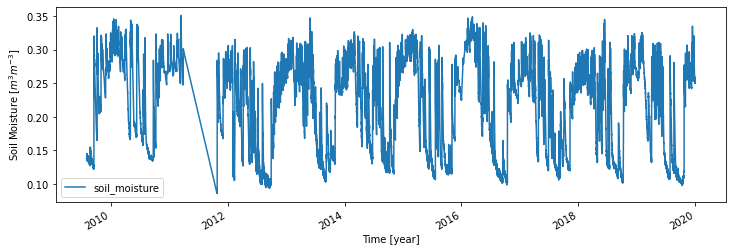

In [12]:
sensor = ismn_data['SMOSMANIA']['SaintFelixdeLauragais']['ThetaProbe-ML2X_soil_moisture_0.050000_0.050000']
print(sensor.metadata.to_pd())
ts = sensor.read_data()
ax = ts.plot(figsize=(12,4))
ax.set_xlabel("Time [year]")
ax.set_ylabel("Soil Moisture [$m^3 m^{-3}$]")
display(ts)

Some metadata is different for each sensor (e.g. time series range), some depends on the location of the station and is therefore shared by multiple sensors at one station (landcover and climate classes etc.). Sometime metadata is missing (if not provided, indicated by 'unknown', or NaN). Some meta data depends on the depth of a sensor (e.g. soil properties), during metadata collection (in the beginning) these values were collected and assigned.

In [13]:
sensor.metadata.to_dict()

{'clay_fraction': [(22.8, 0.05, 0.05)],
 'climate_KG': [('Cfb', None, None)],
 'climate_insitu': [('unknown', None, None)],
 'elevation': [(337.0, None, None)],
 'instrument': [('ThetaProbe-ML2X', 0.05, 0.05)],
 'latitude': [(43.4417, None, None)],
 'lc_2000': [(10, None, None)],
 'lc_2005': [(10, None, None)],
 'lc_2010': [(10, None, None)],
 'lc_insitu': [('unknown', None, None)],
 'longitude': [(1.88, None, None)],
 'network': [('SMOSMANIA', None, None)],
 'organic_carbon': [(1.15, 0.05, 0.05)],
 'sand_fraction': [(43.5, 0.05, 0.05)],
 'saturation': [(0.44, 0.05, 0.05)],
 'silt_fraction': [(33.7, 0.05, 0.05)],
 'station': [('SaintFelixdeLauragais', None, None)],
 'timerange_from': [(Timestamp('2009-08-04 00:00:00'), None, None)],
 'timerange_to': [(Timestamp('2020-01-01 00:00:00'), None, None)],
 'variable': [('soil_moisture', 0.05, 0.05)]}

## Some other important functions
Each component (network, station, sensor) conains differnet functions to handle its data. ISMN_Interface provides general functions to filter and iterate over its components and visualise them.

### Find nearest station
The data collection in ISMN_Interface contains a grid object that contains the locations of all **stations** in all active networks. For more details see https://github.com/TUW-GEO/pygeogrids

In [15]:
import pandas as pd
grid = ismn_data.collection.grid
gpis, lons, lats = grid.get_grid_points()
pd.DataFrame(index=pd.Index(gpis, name='gpi'), 
             data={'lon': lons, 'lat': lats}).T

gpi,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
lon,27.55062,27.55076,27.53543,26.63378,26.63378,26.63378,26.65176,26.65162,26.65196,26.65064,...,15.81499,15.94361,15.96578,15.75960,15.85507,15.90710,15.92462,16.04056,15.78112,16.03337
lat,68.33019,68.33025,68.33881,67.36187,67.36179,67.36195,67.36691,67.36685,67.36691,67.36702,...,46.97232,46.97125,46.95952,46.94327,46.99726,46.93296,46.93291,46.93427,46.91691,46.92135


In [19]:
# Using the GPI or coordinates, a station from **all** stations in **all** networks in the collection can be selected.
station, dist = ismn_data.collection.get_nearest_station(27.0, 68.0)
print(f'Station {station.name} is {int(dist)} metres away from the passed coordinates:')
assert collection.station4gpi(0) == station # same result when selecting with GPI
station

Station SAA111 is 43348 metres away from the passed coordinates:


Sensors at 'SAA111': ['CS215_air_temperature_-2.000000_-2.000000', '5TE_soil_temperature_0.200000_0.200000', '5TE_soil_temperature_0.400000_0.400000', '5TE_soil_moisture_0.800000_0.800000', '5TE_soil_moisture_0.400000_0.400000', '5TE_soil_moisture_0.200000_0.200000', '5TE_soil_temperature_0.050000_0.050000', '5TE_soil_moisture_0.050000_0.050000', '5TE_soil_moisture_0.100000_0.100000', '5TE_soil_temperature_0.800000_0.800000', '5TE_soil_temperature_0.100000_0.100000']

### Find network for a specific station
`ISMN_Interface` provides a function to find the network when only the name of a station is known. Here we simply read data for the first available sensor at the fist station in the found network.

In [24]:
network = ismn_data.network_for_station('SAA111', name_only=False)
station = network[0]
sensor = station[0]
display(network, station, sensor)
sensor.read_data()

Stations in 'FMI': ['SAA111', 'SAA112', 'SAA120', 'SOD011', 'SOD012', 'SOD013', 'SOD021', 'SOD022', 'SOD023', 'SOD031', 'SOD032', 'SOD033', 'SOD071', 'SOD072', 'SOD073', 'SOD081', 'SOD082', 'SOD083', 'SOD091', 'SOD092', 'SOD093', 'SOD101', 'SOD102', 'SOD103', 'SOD130', 'SOD140', 'SODAWS']

Sensors at 'SAA111': ['CS215_air_temperature_-2.000000_-2.000000', '5TE_soil_temperature_0.200000_0.200000', '5TE_soil_temperature_0.400000_0.400000', '5TE_soil_moisture_0.800000_0.800000', '5TE_soil_moisture_0.400000_0.400000', '5TE_soil_moisture_0.200000_0.200000', '5TE_soil_temperature_0.050000_0.050000', '5TE_soil_moisture_0.050000_0.050000', '5TE_soil_moisture_0.100000_0.100000', '5TE_soil_temperature_0.800000_0.800000', '5TE_soil_temperature_0.100000_0.100000']

CS215_air_temperature_-2.000000_-2.000000

,air_temperature,air_temperature_flag,air_temperature_orig_flag
date_time,,,
2012-09-19 11:00:00,0.1,G,M
2012-09-19 12:00:00,0.1,G,M
2012-09-19 13:00:00,0.2,G,M
2012-09-19 14:00:00,0.2,G,M
2012-09-19 15:00:00,0.1,G,M
...,...,...,...
2020-12-12 19:00:00,-11.4,G,M
2020-12-12 20:00:00,-11.2,G,M
2020-12-12 21:00:00,-10.8,G,M


 ### Selecting and reading specific sensors

We can filter the dataset a priori and get ids of sensors that measure a specific variable. The id can then be used to read the data directly. Here we exract the ids of sensors in our data set that measure 'soil_temperature' in 0 to 1 metre depth and within a specific land cover and climate class (all conditions must be fulfilled).

In [25]:
ids = ismn_data.get_dataset_ids(variable='soil_temperature', 
                                max_depth=1, 
                                filter_meta_dict={'lc_2005': 130, 'climate_KG': 'Csb'})
ids

[464, 465, 466, 467]

Now we can use the so found ids to read data from according sensors.

Text(0, 0.5, 'Soil Temp. [°C]')

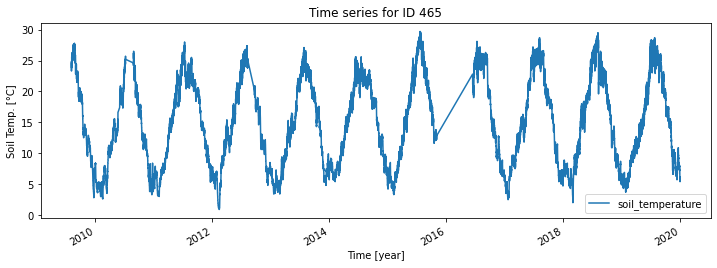

In [26]:
ts, meta = ismn_data.read(ids[1], return_meta=True)
meta
ax = ts.plot(figsize=(12,4), title=f'Time series for ID {ids[1]}')
ax.set_xlabel("Time [year]")
ax.set_ylabel("Soil Temp. [°C]")

We can define a similar query to plot station locations for a specific variable on a map. If a min/max depth is passed, only stations with a sensor that measures within the passed range are included. Note that this kind of visulisation needs additional (optional) packages installed (use `pip install ismn[plot]` to install them.)

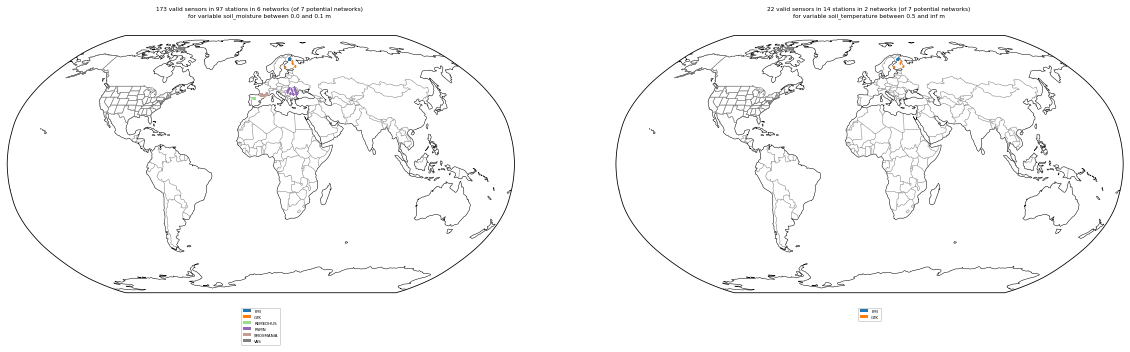

In [29]:
import cartopy.crs as ccrs
#plot available station on a map
fig, axs = plt.subplots(1, 2, figsize=(16,10), subplot_kw={'projection': ccrs.Robinson()})
ismn_data.plot_station_locations('soil_moisture', min_depth=0., max_depth=0.1, ax=axs[0])
ismn_data.plot_station_locations('soil_temperature', min_depth=0.5, ax=axs[1])
plt.show()


## Selecting and interating over sensors

It is often desired to iterate over all sensors that fulfill certain conditions (e.g. that measure soil moisture in a certain depth, and/or for a certain landcover class). For these cases the `collection` (and other components) provides iterators that take keywords and values for filtering the loaded networks/stations/sensor while iterating over single time series (of a whole collection, a network, or a station).

### Select  by variable and depth
In this example we iterate over all sensors in the previously loaded collection (i.e. over all activated networks) that measure 'soil_moisture' in any depth (range) between 0 and 0.05 metres.

Stations in 'FMI': ['SAA111', 'SAA112', 'SAA120', 'SOD011', 'SOD012', 'SOD013', 'SOD021', 'SOD022', 'SOD023', 'SOD031', 'SOD032', 'SOD033', 'SOD071', 'SOD072', 'SOD073', 'SOD081', 'SOD082', 'SOD083', 'SOD091', 'SOD092', 'SOD093', 'SOD101', 'SOD102', 'SOD103', 'SOD130', 'SOD140', 'SODAWS']

Sensors at 'SAA111': ['CS215_air_temperature_-2.000000_-2.000000', '5TE_soil_temperature_0.200000_0.200000', '5TE_soil_temperature_0.400000_0.400000', '5TE_soil_moisture_0.800000_0.800000', '5TE_soil_moisture_0.400000_0.400000', '5TE_soil_moisture_0.200000_0.200000', '5TE_soil_temperature_0.050000_0.050000', '5TE_soil_moisture_0.050000_0.050000', '5TE_soil_moisture_0.100000_0.100000', '5TE_soil_temperature_0.800000_0.800000', '5TE_soil_temperature_0.100000_0.100000']

5TE_soil_moisture_0.050000_0.050000

Metadata for sensor 5TE_soil_moisture_0.050000_0.050000:


name            meta_args 
clay_fraction   val                             4
                depth_from                      0
                depth_to                      0.3
climate_KG      val                           Dfc
climate_insitu  val                       unknown
elevation       val                           441
instrument      val                           5TE
                depth_from                   0.05
                depth_to                     0.05
latitude        val                       68.3302
lc_2000         val                           110
lc_2005         val                           110
lc_2010         val                           110
lc_insitu       val                       unknown
longitude       val                       27.5506
network         val                           FMI
nw_from_folder  val                           FMI
organic_carbon  val                          2.18
                depth_from                      0
                depth_t

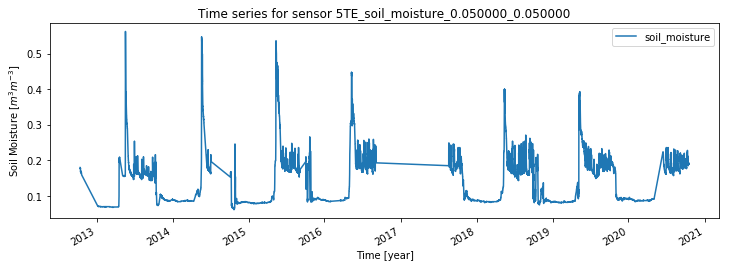

In [39]:
for network, station, sensor in ismn_data.collection.iter_sensors(variable='soil_moisture', 
                                                                  depth=[0., 0.05]):
    display(network)
    display(station)
    display(sensor)

    data = sensor.read_data()

    print('\033[1m' + f'Metadata for sensor {sensor}:'+ '\033[0m')
    display(sensor.metadata.to_pd())
    ax = data.plot(figsize=(12,4), title=f'Time series for sensor {sensor.name}')
    ax.set_xlabel("Time [year]")
    ax.set_ylabel("Soil Moisture [$m^3 m^{-3}$]")
    break  # for this example we stop after the first sensor

### Selecting by variable and other metadata (1)
In this example we iterate over all sensors for the network 'RMSN' and filter out those that measure precipitation within an ESA CCI Landcover pixel that is marked as 'Cropland, rainfed' (10) or 'Grassland' (130).

In [16]:
ismn_data.print_landcover_dict()

CCI Landcover Classification
----------------------------
Cropland, rainfed: 10
Cropland, rainfed / Herbaceous cover: 11
Cropland, rainfed / Tree or shrub cover: 12
Cropland, irrigated or post-flooding: 20
Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous: 30
Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%): 40
Tree cover, broadleaved, evergreen, Closed to open (>15%): 50
Tree cover, broadleaved, deciduous, Closed to open (>15%): 60
Tree cover, broadleaved, deciduous, Closed (>40%): 61
Tree cover, broadleaved, deciduous, Open (15-40%): 62
Tree cover, needleleaved, evergreen, closed to open (>15%): 70
Tree cover, needleleaved, evergreen, closed (>40%): 71
Tree cover, needleleaved, evergreen, open (15-40%): 72
Tree cover, needleleaved, deciduous, closed to open (>15%): 80
Tree cover, needleleaved, deciduous, closed (>40%): 81
Tree cover, needleleaved, deciduous, open (15-40%): 82
Tree cover, mixed leaf type (broadleaved and needleleave

Sensors at 'Barlad': ['HMP155-Vaisala_air_temperature_-2.000000_-2.000000', '5TM_soil_temperature_0.000000_0.050000', '5TM_soil_moisture_0.000000_0.050000', 'QMR102_precipitation_-1.400000_-1.400000', 'HMP155_air_temperature_-2.000000_-2.000000']

QMR102_precipitation_-1.400000_-1.400000

Metadata for sensor QMR102_precipitation_-1.400000_-1.400000:


name            meta_args 
climate_KG      val                           Dfb
climate_insitu  val                       unknown
elevation       val                           172
instrument      val                        QMR102
                depth_from                   -1.4
                depth_to                     -1.4
latitude        val                       46.2331
lc_2000         val                            10
lc_2005         val                            10
lc_2010         val                            10
lc_insitu       val                       unknown
longitude       val                       27.6444
network         val                          RSMN
nw_from_folder  val                          RSMN
station         val                        Barlad
timerange_from  val           2014-06-06 07:00:00
timerange_to    val           2020-10-31 23:00:00
variable        val                 precipitation
                depth_from                   -1.4
                depth_t

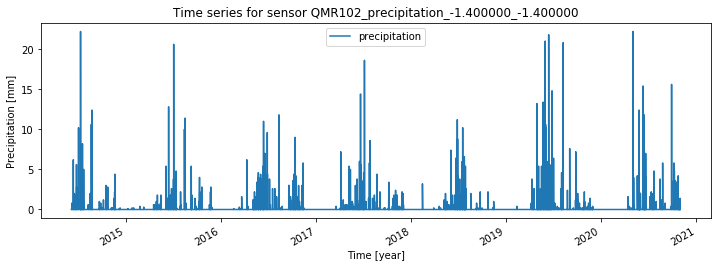

In [40]:
for station, sensor in ismn_data['RSMN'].iter_sensors(variable='precipitation', 
                                                      filter_meta_dict={'lc_2010': [10, 130]}):
    display(station)
    display(sensor)
    
    data = sensor.read_data()
    metadata = sensor.metadata
    
    print('\033[1m' + f'Metadata for sensor {sensor}:' + '\033[0m')
    display(metadata.to_pd())
    ax = data.plot(figsize=(12,4), title=f'Time series for sensor {sensor.name}')
    ax.set_xlabel("Time [year]")
    ax.set_ylabel("Precipitation [mm]")
    break # for this example we stop after the first sensor

### Selecting by variable, depth and metadata (2)
In this example we iterate over all sensors in the collection and filter those that measure soil_moisture between 0 and 10 cm within an ESA CCI Landcover pixel that is marked as 'Cropland, rainfed' (10) or 'Grassland' (130), and has one of the follwing climate classes assigned: Csc, Cfa, Dfc. In addition we set all those soil moisture values that are **not** flagged as 'good' (G) to NaN.

In [18]:
display(ismn_data.print_climate_dict())

KOEPPEN GEIGER Climate Classification
-------------------------------------
Af  : Tropical Rainforest
Am  : Tropical Monsoon
As  : Tropical Savanna Dry
Aw  : Tropical Savanna Wet
BWk : Arid Desert Cold
BWh : Arid Desert Hot
BWn : Arid Desert With Frequent Fog
BSk : Arid Steppe Cold
BSh : Arid Steppe Hot
BSn : Arid Steppe With Frequent Fog
Csa : Temperate Dry Hot Summer
Csb : Temperate Dry Warm Summer
Csc : Temperate Dry Cold Summer
Cwa : Temperate Dry Winter, Hot Summer
Cwb : Temperate Dry Winter, Warm Summer
Cwc : Temperate Dry Winter, Cold Summer
Cfa : Temperate Without Dry Season, Hot Summer
Cfb : Temperate Without Dry Season, Warm Summer
Cfc : Temperate Without Dry Season, Cold Summer
Dsa : Cold Dry Summer, Hot Summer
Dsb : Cold Dry Summer, Warm Summer
Dsc : Cold Dry Summer, Cold Summer
Dsd : Cold Dry Summer, Very Cold Winter
Dwa : Cold Dry Winter, Hot Summer
Dwb : Cold Dry Winter, Warm Summer
Dwc : Cold Dry Winter, Cold Summer
Dwd : Cold Dry Winter, Very Cold Winter
Dfa : Cold Dry

None

Stations in 'RSMN': ['Adamclisi', 'Alexandria', 'Bacles', 'Banloc', 'Barlad', 'Calarasi', 'ChisineuCris', 'Corugea', 'Cotnari', 'Darabani', 'Dej', 'Dumbraveni', 'Iasi', 'Oradea', 'RosioriideVede', 'SannicolauMare', 'SatuMare', 'Slatina', 'Slobozia', 'Tecuci']

Sensors at 'Dumbraveni': ['5TM_soil_moisture_0.000000_0.050000', '5TM_soil_temperature_0.000000_0.050000', 'QMR102_precipitation_-1.400000_-1.400000', 'HMP45DX_air_temperature_-2.000000_-2.000000']

5TM_soil_moisture_0.000000_0.050000

Metadata for sensor 5TM_soil_moisture_0.000000_0.050000:


name            meta_args 
clay_fraction   val                            19
                depth_from                      0
                depth_to                      0.3
climate_KG      val                           Dfc
climate_insitu  val                       unknown
elevation       val                           318
instrument      val                           5TM
                depth_from                      0
                depth_to                     0.05
latitude        val                       46.2279
lc_2000         val                            10
lc_2005         val                            10
lc_2010         val                            10
lc_insitu       val                       unknown
longitude       val                       24.5916
network         val                          RSMN
nw_from_folder  val                          RSMN
organic_carbon  val                          0.99
                depth_from                      0
                depth_t

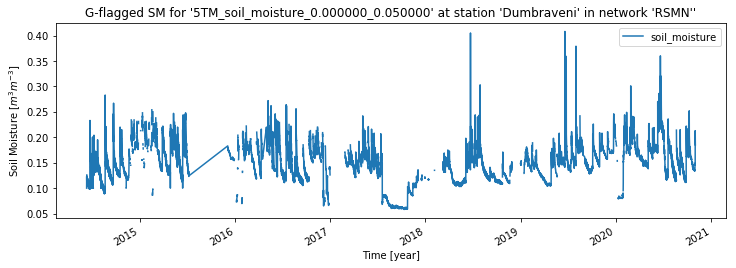

In [41]:
from ismn.meta import Depth
for network, station, sensor in ismn_data.collection \
    .iter_sensors(variable='soil_moisture',
                  depth=Depth(0.,0.05),
                  filter_meta_dict={'lc_2010': [10, 130],
                                    'climate_KG':['Csc', 'Cfa', 'Dfc']}):
    
    display(network)
    display(station)
    display(sensor)
    
    data = sensor.read_data()
    data.loc[data['soil_moisture_flag'] != 'G', 'soil_moisture'] = np.nan
    metadata = sensor.metadata

    print('\033[1m' + f'Metadata for sensor {sensor}:'+ '\033[0m')
    display(metadata.to_pd())
    ax = data.plot(figsize=(12,4), title=f"G-flagged SM for '{sensor.name}' at station '{station.name}' in network '{network.name}''")
    ax.set_xlabel("Time [year]")
    ax.set_ylabel("Soil Moisture [$m^3 m^{-3}$]")
    break # for this example we stop after the first sensor